#### XGBoost Model

***

The following notebook contains code for training, tuning, and testing an XGBoost model trained on Wavelet Features from *fire* and *non-fire* images.

In [1]:
import numpy as np
import xgboost as xgb

from bayes_opt import BayesianOptimization

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

In [2]:
# Load the Wavelet Features.
wav_01 = np.loadtxt("WAV__effective_forest_fire_detection.csv", delimiter = ",", dtype = np.float32)
wav_02 = np.loadtxt("WAV__fire_dataset.csv", delimiter = ",", dtype = np.float32)

# Combine both files into a single matrix.
wav_ft = np.vstack([wav_01, wav_02])
wav_ft.shape

(4507, 55)

In [3]:
# Separate data into predictors (X) and label (y).
X = wav_ft[:, :-1]
y = wav_ft[:, -1]

# Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 226)

# Split into validation set.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 226)

In [4]:
# Convert sets into DMatrices (required by XGBoost).
d_train = xgb.DMatrix(X_train, label = y_train, enable_categorical = False)
d_val = xgb.DMatrix(X_val, label = y_val, enable_categorical = False)
d_test = xgb.DMatrix(X_test, enable_categorical = False)

- The following dictionary contains the default hyperparameters for XGBoost.
  - `"objective": "binary:logistic"` tells XGBoost we are doing binary classification.
  - `"eval_metric": "logloss"` is the evaluation metric.

In [5]:
parameters = {
    # Parameters for Tree Booster
    "max_depth": 6,
    "min_child_weight": 1,
    "eta": 0.3,
    "subsample": 0.5,
    "colsample_bytree": 0.1,
    "reg_lambda": 0,
    "reg_alpha": 1,
    "min_split_loss": 0,

    # Learning Task Parameters
    "objective": "binary:logistic",
    "eval_metric": "logloss"
}

# Bounds for Bayesian Optimization.
bo_bounds = {
    "max_depth": (1, 250),
    "min_child_weight": (1, 250),
    "colsample_bytree": (0, 1),
    "alpha_vals": (0, 500),
    "lambda_vals": (0, 1),
    "gamma_vals": (0, 100),
    "eta": (0.2, 0.6)
}

The following is a helper function for tuning the model. It will update the parameter dictionary and train a model with the target parameters, returning the loss for the training.

In [6]:
def bo_tune(max_depth, min_child_weight, colsample_bytree,
            alpha_vals, lambda_vals, gamma_vals,
            eta):

    parameters["max_depth"] = int(max_depth)
    parameters["min_child_weight"] = int(min_child_weight)
    parameters["colsample_bytree"] = colsample_bytree
    parameters["reg_alpha"] = alpha_vals
    parameters["reg_lambda"] = lambda_vals
    parameters["min_split_loss"] = gamma_vals
    parameters["eta"] = eta

    test_performance = {}

    xgb.train(
        parameters,
        d_train,
        num_boost_round = 999,
        evals = [(d_val, "BO_Val")],
        evals_result = test_performance,
        early_stopping_rounds = 20,
        verbose_eval = False,
    )

    test_mae = min(test_performance["BO_Val"]["logloss"])

    # Retrieve the loss from the test.
    return test_mae * -1.0

In [7]:
# Tune the model parameters using Bayesian Optimization.
# Every time, a new model is trained with a different parameter combination.
# We try to maximize the negative logloss.
model_bo = BayesianOptimization(bo_tune, pbounds = bo_bounds,
                                verbose = 2, random_state = 226)
model_bo.maximize(init_points = 10, n_iter = 70)

|   iter    |  target   | alpha_... | colsam... |    eta    | gamma_... | lambda... | max_depth | min_ch... |
-------------------------------------------------------------------------------------------------------------
| 1         | -0.6931   | 447.5     | 0.3448    | 0.474     | 71.36     | 0.3167    | 234.2     | 118.9     |
| 2         | -0.6931   | 198.2     | 0.3241    | 0.2704    | 56.39     | 0.7375    | 130.8     | 15.69     |
| 3         | -0.6931   | 411.5     | 0.612     | 0.2443    | 67.56     | 0.3074    | 69.24     | 127.6     |
| 4         | -0.6931   | 489.6     | 0.1261    | 0.4574    | 75.28     | 0.222     | 85.71     | 221.5     |
| 5         | -0.4759   | 18.85     | 0.2068    | 0.3489    | 2.105     | 0.4243    | 28.35     | 120.9     |
| 6         | -0.6931   | 310.3     | 0.5066    | 0.4224    | 2.027     | 0.8524    | 159.0     | 223.0     |
| 7         | -0.6931   | 221.7     | 0.3445    | 0.427     | 36.75     | 0.3669    | 6.498     | 92.38     |
| 8       

In [8]:
# Retrieve the best parameters.
bo_params = model_bo.max["params"]

# Update the parameter dictionary with the best parameters.
parameters["max_depth"] = int(bo_params["max_depth"])
parameters["min_child_weight"] = int(bo_params["min_child_weight"])
parameters["colsample_bytree"] = bo_params["colsample_bytree"]
parameters["reg_alpha"] = bo_params["alpha_vals"]
parameters["reg_lambda"] = bo_params["lambda_vals"]
parameters["min_split_loss"] = bo_params["gamma_vals"]
parameters["eta"] = bo_params["eta"]

In [9]:
# Train a model using tuned parameters to find the ideal number of boosting rounds.
boost_rnds_model = xgb.train(
    parameters,
    d_train,
    num_boost_round = 999,
    evals = [(d_val, "Boosting_Rounds_Test")],
    early_stopping_rounds = 25,
)

[0]	Boosting_Rounds_Test-logloss:0.38312
[1]	Boosting_Rounds_Test-logloss:0.27855
[2]	Boosting_Rounds_Test-logloss:0.23015
[3]	Boosting_Rounds_Test-logloss:0.19437
[4]	Boosting_Rounds_Test-logloss:0.17532
[5]	Boosting_Rounds_Test-logloss:0.16028
[6]	Boosting_Rounds_Test-logloss:0.15140
[7]	Boosting_Rounds_Test-logloss:0.15148
[8]	Boosting_Rounds_Test-logloss:0.15015
[9]	Boosting_Rounds_Test-logloss:0.14424
[10]	Boosting_Rounds_Test-logloss:0.13759
[11]	Boosting_Rounds_Test-logloss:0.13675
[12]	Boosting_Rounds_Test-logloss:0.13649
[13]	Boosting_Rounds_Test-logloss:0.13929
[14]	Boosting_Rounds_Test-logloss:0.14200
[15]	Boosting_Rounds_Test-logloss:0.14342
[16]	Boosting_Rounds_Test-logloss:0.14417
[17]	Boosting_Rounds_Test-logloss:0.14522
[18]	Boosting_Rounds_Test-logloss:0.14754
[19]	Boosting_Rounds_Test-logloss:0.14760
[20]	Boosting_Rounds_Test-logloss:0.15068
[21]	Boosting_Rounds_Test-logloss:0.15151
[22]	Boosting_Rounds_Test-logloss:0.15416
[23]	Boosting_Rounds_Test-logloss:0.15196
[2

In [10]:
# Re-train model with ideal number of boosting rounds.
tuned_model = xgb.train(
    parameters,
    d_train,
    num_boost_round = boost_rnds_model.best_iteration + 1,
)

In [11]:
# Use model to make a prediction of the testing set.
y_pred = tuned_model.predict(d_test)

In [12]:
# Convert prediction scores to classes.
y_pred[y_pred > 0.8] = 1
y_pred[y_pred <= 0.8] = 0

In [13]:
# Get the accuracy score of our prediction.
accuracy_score(y_pred, y_test) * 100

93.12638580931264

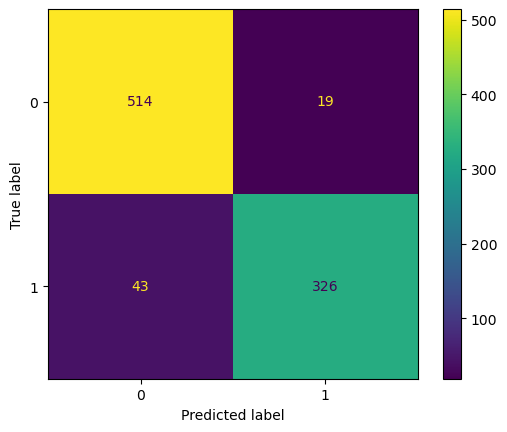

In [14]:
# Plot a confusion matrix of the prediction.
conf_matrix = confusion_matrix(y_test, y_pred)
cofn_plt = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
cofn_plt.plot()
plt.show()

In [15]:
# Save the tuned model.
tuned_model.save_model("tuned_model.json")